In [1]:
!pip install pandas numpy scikit-learn torch transformers tqdm lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=6721f54bd3c605b6d4c35e7092dbe5995ca99abc021dda4a079a1cf3107b6c23
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import lime
import lime.lime_text

# Load and preprocess data
df = pd.read_csv('grants_final.tsv', sep='\t')
df = df[['Title', 'Theme']].copy()
df = df.drop_duplicates()
df = df.dropna()
df['Title'] = df['Title'].str.strip('"')
df['Theme'] = df['Theme'].str.strip("'")

print(f"Total samples before filtering: {len(df)}")
print(f"Number of unique themes before filtering: {df['Theme'].nunique()}")

# Set threshold for minimum number of samples per theme
MIN_SAMPLES_PER_THEME = 4 # Adjust this value as needed

theme_counts = df['Theme'].value_counts()
print(f"\nTheme distribution before filtering:\n{theme_counts}")

# Keep only themes with at least MIN_SAMPLES_PER_THEME samples
valid_themes = theme_counts[theme_counts >= MIN_SAMPLES_PER_THEME].index
df = df[df['Theme'].isin(valid_themes)]

print(f"\n{'='*60}")
print(f"After filtering themes with < {MIN_SAMPLES_PER_THEME} samples:")
print(f"Total samples: {len(df)}")
print(f"Number of unique themes: {df['Theme'].nunique()}")
print(f"\nTheme distribution after filtering:\n{df['Theme'].value_counts()}")

Total samples before filtering: 298
Number of unique themes before filtering: 29

Theme distribution before filtering:
Theme
Education & Workforce Development         44
AI / Machine Learning                     33
Cybersecurity                             29
Healthcare / Biomedical                   28
Environment & Agriculture                 17
Data / Metadata / Scientific Data         16
Robotics & CPS                            13
Quantum                                   13
Sensors / IoT / Edge                      13
Algorithms / Theory / Optimization        11
Software / Systems                        10
Networking & Communications                9
Privacy / Machine Learning                 8
Blockchain & Privacy                       8
Human-centered / Social / Anthropology     7
Disaster / Resilience / Evacuation         6
Manufacturing / Advanced Manufacturing     6
Visualization / Analytics                  5
Energy / Environment                       4
Materials & Chemistr

In [4]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Theme'])

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

print(f"\nTraining samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")

tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit and transform data
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['Title'])
y_train = train_df['label']
X_test_tfidf = tfidf_vectorizer.transform(test_df['Title'])
y_test = test_df['label']


Training samples: 230
Testing samples: 58


In [5]:
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [6]:
# y_pred = logistic_model.predict(X_test_tfidf)
# print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
# print("\nClassification Report:")
# print(classification_report(
#     y_test,
#     y_pred,
#     target_names=label_encoder.classes_,
#     zero_division=0
# ))

In [7]:
class_names = label_encoder.classes_

def predict_proba_lime(texts):
    """
    Wrapper function for LIME to get prediction probabilities.
    Takes raw text, vectorizes it, and returns class probabilities.
    """
    X_tfidf = tfidf_vectorizer.transform(texts)
    return logistic_model.predict_proba(X_tfidf)

In [8]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=class_names)

def predict_theme_and_explain(title, k=3, num_features=5):

    X_new = tfidf_vectorizer.transform([title])
    probabilities = logistic_model.predict_proba(X_new)[0]
    top_k_indices = np.argsort(probabilities)[::-1][:k]

    results = []
    for idx in top_k_indices:
        predicted_label = idx
        predicted_theme = label_encoder.inverse_transform([predicted_label])[0]
        confidence = probabilities[predicted_label]

        # Generate LIME explanation for the predicted label
        explanation = explainer.explain_instance(
            text_instance=title,
            classifier_fn=predict_proba_lime,
            labels=[predicted_label],
            num_features=num_features
        )

        exp_list = explanation.as_list(label=predicted_label)
        results.append({
            'predicted_theme': predicted_theme,
            'confidence': confidence,
            'explanation': exp_list
        })

    return results

In [9]:
# Example predictions with LIME explanations
print("\n" + "="*50)
print("Example Predictions with LIME Explanations (Top K):")
print("="*50)

example_titles = [
    "Integration of Quantum Computing for STEM Education",
    "Patient monitoring and sensor data for healthcare",
    "Secure network protocols and intrusion detection"
]

for title in example_titles:
    print(f"\nTitle: {title}")
    top_k_predictions = predict_theme_and_explain(title, k=3)
    for i, pred_info in enumerate(top_k_predictions):
        predicted_theme = pred_info['predicted_theme']
        confidence = pred_info['confidence']
        explanation = pred_info['explanation']
        print(f"  Top {i+1} Predicted Theme: {predicted_theme} (Confidence: {confidence:.2f})")
        print(f"  Explanation for '{predicted_theme}':")
        for word, weight in explanation:
            print(f"    - {word}: {weight:.4f}")


Example Predictions with LIME Explanations (Top K):

Title: Integration of Quantum Computing for STEM Education
  Top 1 Predicted Theme: Education & Workforce Development (Confidence: 0.47)
  Explanation for 'Education & Workforce Development':
    - Education: 0.1242
    - STEM: 0.1170
    - Computing: 0.1054
    - Integration: -0.0568
    - Quantum: -0.0349
  Top 2 Predicted Theme: Quantum (Confidence: 0.06)
  Explanation for 'Quantum':
    - Quantum: 0.0522
    - Education: -0.0267
    - STEM: -0.0261
    - Integration: -0.0114
    - Computing: 0.0048
  Top 3 Predicted Theme: AI / Machine Learning (Confidence: 0.06)
  Explanation for 'AI / Machine Learning':
    - Computing: -0.0158
    - Education: -0.0138
    - STEM: -0.0128
    - Integration: 0.0074
    - Quantum: -0.0050

Title: Patient monitoring and sensor data for healthcare
  Top 1 Predicted Theme: Environment & Agriculture (Confidence: 0.12)
  Explanation for 'Environment & Agriculture':
    - monitoring: 0.0440
    - heal


Visualizing LIME explanations for title: Designer Cells seeks projects that use the tools of synthetic biology to better understand how the systems and components of cells are built. This includes what is required for the components and systems to function properly, and to explore molecular and cellular diversity beyond what exists in nature. The synthetic cell components or systems that may be generated and analyzed include ribosomes, mitochondria, membranes, regulatory modules, sensory systems, and molecular machines. These may be integrated into synthetic cells or cell-like systems, and they may be designed with novel molecular building blocks to study the design spaces evolution has not sampled or selected. Projects that aim to identify systems or components that are required for cells to function properly, or those that are dispensable, by generating stripped-down or minimal versions of cells, are welcome. All projects submitted in this research area should include a consideratio

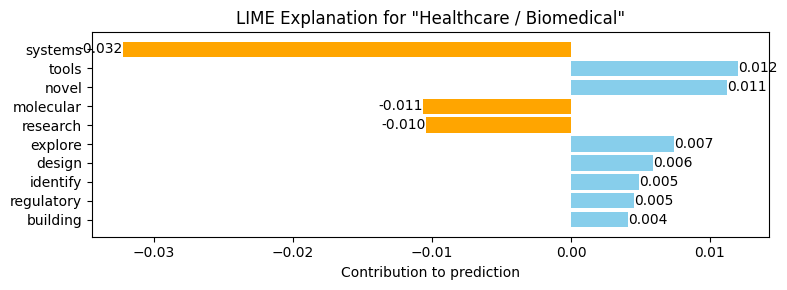

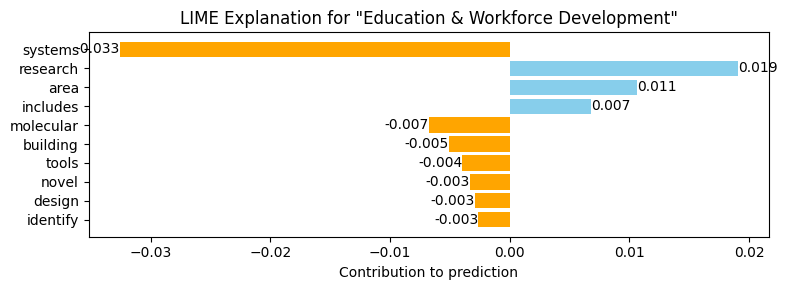

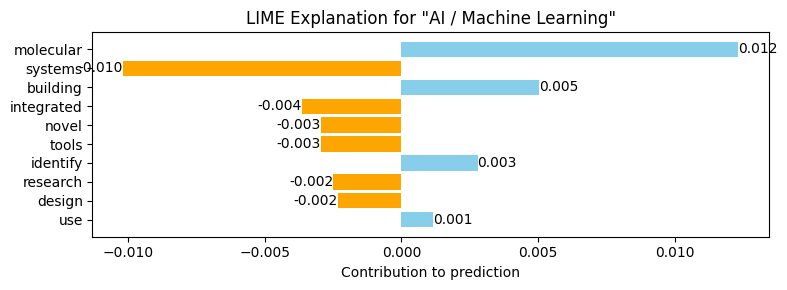

In [10]:
import matplotlib.pyplot as plt

# Example usage:
example_title = "Designer Cells seeks projects that use the tools of synthetic biology to better understand how the systems and components of cells are built. This includes what is required for the components and systems to function properly, and to explore molecular and cellular diversity beyond what exists in nature. The synthetic cell components or systems that may be generated and analyzed include ribosomes, mitochondria, membranes, regulatory modules, sensory systems, and molecular machines. These may be integrated into synthetic cells or cell-like systems, and they may be designed with novel molecular building blocks to study the design spaces evolution has not sampled or selected. Projects that aim to identify systems or components that are required for cells to function properly, or those that are dispensable, by generating stripped-down or minimal versions of cells, are welcome. All projects submitted in this research area should include a consideration of the risks and benefits of the research and other relevant societal implications."
# example_title = "Quantum for STEM Education"
# Get predictions and explanations
# Change k to the desired number of themes to visualize
# Change num_features to the desired number of words in the explanation
top_k_predictions = predict_theme_and_explain(example_title, k=3, num_features=10)

print(f"\nVisualizing LIME explanations for title: {example_title}")

for pred_info in top_k_predictions:
    predicted_theme = pred_info['predicted_theme']
    explanation = pred_info['explanation'] # This is already in as_list format

    if explanation:
        words, scores = zip(*explanation)
        colors = ['orange' if score < 0 else 'skyblue' for score in scores]

        plt.figure(figsize=(8, 3))
        bars = plt.barh(words, scores, color=colors)
        plt.xlabel('Contribution to prediction')
        plt.title(f'LIME Explanation for "{predicted_theme}"')
        plt.gca().invert_yaxis()

        for bar, score in zip(bars, scores):
            plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
                     f'{score:.3f}', va='center', ha='left' if score > 0 else 'right',
                     color='black', fontsize=10)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No explanation available for theme: {predicted_theme}")


In [11]:
import pandas as pd
import numpy as np
from datetime import datetime
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

class ResearcherRecommendationSystem:
    def __init__(self, grants_df, current_year=2026, label_encoder=None, tfidf_vectorizer=None, logistic_model=None):
        """
        Initialize the recommendation system with grants data

        Args:
            grants_df: DataFrame with columns [ProposalNo, Title, Year, Researchers, Theme]
            current_year: Current year for recency calculation
            label_encoder: Fitted LabelEncoder for theme labels
            tfidf_vectorizer: Fitted TfidfVectorizer for text transformation
            logistic_model: Trained LogisticRegression model for theme prediction
        """
        self.current_year = current_year
        self.grants_df = grants_df.copy()
        self.label_encoder = label_encoder
        self.tfidf_vectorizer = tfidf_vectorizer
        self.logistic_model = logistic_model

        # Parse the data
        self._parse_grants_data()

        # Build researcher profiles
        self._build_researcher_profiles()

        # Initialize TF-IDF for title similarity
        self._initialize_title_similarity()

    def _parse_grants_data(self):
        """Parse and clean the grants data"""
        # Clean up columns
        self.grants_df['Title'] = self.grants_df['Title'].str.strip('"')
        self.grants_df['Theme'] = self.grants_df['Theme'].str.strip("'")
        self.grants_df['Researchers'] = self.grants_df['Researchers'].str.strip("'")

        # Parse researchers (comma-separated)
        self.grants_df['researcher_list'] = self.grants_df['Researchers'].apply(
            lambda x: [r.strip().strip("'") for r in x.split(',')]
        )

        # Calculate number of researchers per project
        self.grants_df['num_researchers'] = self.grants_df['researcher_list'].apply(len)

        # Create expanded dataframe with one row per researcher per project
        expanded_rows = []
        for _, row in self.grants_df.iterrows():
            researchers = row['researcher_list']
            num_researchers = len(researchers)

            # Assume equal contribution if not specified
            contribution = 100.0 / num_researchers

            for researcher in researchers:
                expanded_rows.append({
                    'ProposalNo': row['ProposalNo'],
                    'Title': row['Title'],
                    'Year': row['Year'],
                    'Theme': row['Theme'],
                    'Researcher': researcher,
                    'Contribution': contribution,
                    'NumResearchers': num_researchers,
                    'IsSolo': num_researchers == 1
                })

        self.expanded_df = pd.DataFrame(expanded_rows)

    def _build_researcher_profiles(self):
        """Build comprehensive profiles for each researcher"""
        self.researcher_profiles = {}

        for researcher in self.expanded_df['Researcher'].unique():
            researcher_projects = self.expanded_df[
                self.expanded_df['Researcher'] == researcher
            ]

            profile = {
                'name': researcher,
                'total_projects': len(researcher_projects),
                'themes': researcher_projects['Theme'].tolist(),
                'theme_counts': researcher_projects['Theme'].value_counts().to_dict(),
                'solo_projects': len(researcher_projects[researcher_projects['IsSolo']]),
                'team_projects': len(researcher_projects[~researcher_projects['IsSolo']]),
                'avg_contribution': researcher_projects['Contribution'].mean(), #Average of contribution percentage
                'recent_projects': researcher_projects[
                    researcher_projects['Year'] >= self.current_year - 3
                ],
                'all_projects': researcher_projects,
                'years_active': researcher_projects['Year'].tolist(),
                'project_titles': researcher_projects['Title'].tolist()
            }

            self.researcher_profiles[researcher] = profile

    def _initialize_title_similarity(self):
        """Initialize TF-IDF vectorizer for title similarity"""
        all_titles = self.grants_df['Title'].tolist()
        self.tfidf = TfidfVectorizer(stop_words='english', max_features=500)
        self.title_vectors = self.tfidf.fit_transform(all_titles)
        self.title_to_idx = {title: idx for idx, title in enumerate(all_titles)}

    def _get_top_k_predicted_themes(self, text, k=2):
        """
        Uses the logistic regression model to predict the top k themes for a given text.
        """
        if self.tfidf_vectorizer is None or self.logistic_model is None or self.label_encoder is None:
            return [] # Cannot predict themes without the model components

        X_new = self.tfidf_vectorizer.transform([text])
        probabilities = self.logistic_model.predict_proba(X_new)[0]
        top_k_indices = np.argsort(probabilities)[::-1][:k]
        top_k_themes = self.label_encoder.inverse_transform(top_k_indices)
        return list(top_k_themes)


    def calculate_researcher_score(self, researcher, target_theme, target_keywords=None,
                                   theme_match_weight=10.0,
                                   keyword_similarity_weight=5.0,
                                   solo_bonus_weight=15.0,
                                   collaboration_bonus_weight=5.0,
                                   recency_bonus_weight=3.0):
        # Calculate score for a researcher based on multiple factors
        profile = self.researcher_profiles.get(researcher)
        if not profile:
            return {'total_score': 0, 'breakdown': {}}

        breakdown = {}

        # 1. Theme Match Score
        theme_matches = profile['theme_counts'].get(target_theme, 0)
        theme_score = theme_matches * theme_match_weight
        breakdown['theme_matches'] = theme_matches
        breakdown['theme_score'] = theme_score

        # 2. Keyword/Title Similarity Score
        keyword_score = 0
        if target_keywords:
            researcher_titles = profile['project_titles']
            if researcher_titles:
                # Vectorize target keywords
                target_vec = self.tfidf.transform([target_keywords])

                # Calculate similarity with researcher's past project titles
                similarities = []
                for title in researcher_titles:
                    if title in self.title_to_idx:
                        title_idx = self.title_to_idx[title]
                        title_vec = self.title_vectors[title_idx]
                        sim = cosine_similarity(target_vec, title_vec)[0][0]
                        similarities.append(sim)

                if similarities:
                    keyword_score = max(similarities) * keyword_similarity_weight * 10

        breakdown['keyword_similarity_score'] = keyword_score

        # 3. Contribution-weighted score
        relevant_projects = profile['all_projects'][
            profile['all_projects']['Theme'] == target_theme
        ]

        contribution_weighted_score = 0
        if len(relevant_projects) > 0:
            contribution_weighted_score = (
                relevant_projects['Contribution'].sum() / 100.0
            ) * theme_match_weight

        breakdown['contribution_weighted_score'] = contribution_weighted_score

        # 4. Solo Bonus
        solo_in_theme = len(relevant_projects[relevant_projects['IsSolo']])
        solo_bonus = solo_in_theme * solo_bonus_weight
        breakdown['solo_projects_in_theme'] = solo_in_theme
        breakdown['solo_bonus'] = solo_bonus

        # 5. Collaboration Bonus
        collaboration_score = 0
        if profile['team_projects'] > 0:
            # Bonus for effective teamwork (high contribution in team projects)
            team_projects = profile['all_projects'][~profile['all_projects']['IsSolo']]
            if len(team_projects) > 0:
                avg_team_contribution = team_projects['Contribution'].mean()
                # Normalize: 50% contribution in team = full bonus
                collaboration_score = (
                    min(avg_team_contribution / 50.0, 1.0) *
                    collaboration_bonus_weight *
                    profile['team_projects']
                )

        breakdown['team_projects'] = profile['team_projects']
        breakdown['collaboration_bonus'] = collaboration_score

        # 6. Recency Bonus
        recent_relevant = profile['recent_projects'][
            profile['recent_projects']['Theme'] == target_theme
        ]
        recency_bonus = len(recent_relevant) * recency_bonus_weight
        breakdown['recent_relevant_projects'] = len(recent_relevant)
        breakdown['recency_bonus'] = recency_bonus

        # Calculate total score
        total_score = (
            theme_score +
            keyword_score +
            contribution_weighted_score +
            solo_bonus +
            collaboration_score +
            recency_bonus
        )

        breakdown['total_score'] = total_score

        return {
            'researcher': researcher,
            'total_score': total_score,
            'breakdown': breakdown,
            'profile_summary': {
                'total_projects': profile['total_projects'],
                'solo_projects': profile['solo_projects'],
                'team_projects': profile['team_projects'],
                'avg_contribution': profile['avg_contribution']
            }
        }

    def recommend_researchers(self, target_theme, target_keywords=None, top_n=5,
                             min_score=0.0, verbose=True):
        """
        Recommend top N researchers for a project, ensuring representation from top predicted themes.

        Args:
            target_theme: Theme of the new project
            target_keywords: Optional project description/title for similarity matching
            top_n: Number of researchers to recommend
            min_score: Minimum score threshold
            verbose: Whether to print detailed explanations

        Returns:
            List of recommended researchers with scores and explanations
        """
        all_scores = []
        top_predicted_themes = []
        if target_keywords and self.logistic_model and self.tfidf_vectorizer and self.label_encoder:
            top_predicted_themes = self._get_top_k_predicted_themes(target_keywords, k=2)

        for researcher in self.researcher_profiles.keys():
            score_data = self.calculate_researcher_score(
                researcher, target_theme, target_keywords
            )
            if score_data['total_score'] >= min_score:
                all_scores.append(score_data)

        all_scores.sort(key=lambda x: x['total_score'], reverse=True)
        final_recommendations = all_scores[:top_n]

        # Ensure at least one researcher from the top 2 predicted themes is included
        if top_predicted_themes:
            has_relevant_researcher = False
            for rec in final_recommendations:
                researcher_profile = self.researcher_profiles[rec['researcher']]
                for theme_in_profile in researcher_profile['themes']:
                    if theme_in_profile in top_predicted_themes:
                        has_relevant_researcher = True
                        break
                if has_relevant_researcher:
                    break

            if not has_relevant_researcher:
                # Find the highest scoring researcher outside the current top_n
                # who has worked on one of the top_predicted_themes
                best_additional_researcher = None
                for researcher_score_data in all_scores[top_n:]: # Look beyond initial top_n
                    researcher_profile = self.researcher_profiles[researcher_score_data['researcher']]
                    for theme_in_profile in researcher_profile['themes']:
                        if theme_in_profile in top_predicted_themes:
                            best_additional_researcher = researcher_score_data
                            break
                    if best_additional_researcher: # Found the best additional one
                        break

                if best_additional_researcher:
                    # If final_recommendations is full, replace the lowest-scoring researcher if the new one is better.
                    # Otherwise, add the new researcher.
                    if len(final_recommendations) == top_n and final_recommendations:
                        lowest_rec = min(final_recommendations, key=lambda x: x['total_score'])
                        if best_additional_researcher['total_score'] > lowest_rec['total_score']:
                            final_recommendations.remove(lowest_rec)
                            final_recommendations.append(best_additional_researcher)
                            final_recommendations.sort(key=lambda x: x['total_score'], reverse=True)
                    elif len(final_recommendations) < top_n:
                        final_recommendations.append(best_additional_researcher)
                        final_recommendations.sort(key=lambda x: x['total_score'], reverse=True)

        if verbose:
            self._print_recommendations(final_recommendations, target_theme, target_keywords)

        return final_recommendations

    def _print_recommendations(self, recommendations, target_theme, target_keywords):
        """Print detailed recommendations with explanations"""
        print("=" * 80)
        print(f"RESEARCHER RECOMMENDATIONS FOR THEME: {target_theme}")
        if target_keywords:
            print(f"Project Keywords/Description: {target_keywords[:100]}...")
        print("=" * 80)

        if not recommendations:
            print("\nNo researchers found matching the criteria.")
            return

        for idx, rec in enumerate(recommendations, 1):
            print(f"\n{'─' * 80}")
            print(f"#{idx}: {rec['researcher']}")
            print(f"{'─' * 80}")
            print(f"OVERALL SCORE: {rec['total_score']:.2f}")

            breakdown = rec['breakdown']
            summary = rec['profile_summary']

            print(f"\nProfile Summary:")
            print(f"   • Total Projects: {summary['total_projects']}")
            print(f"   • Solo Projects: {summary['solo_projects']}")
            print(f"   • Team Projects: {summary['team_projects']}")
            print(f"   • Average Contribution: {summary['avg_contribution']:.1f}%")

            print(f"\nScore Breakdown:")
            print(f"   • Theme Matches: {breakdown['theme_matches']} projects → {breakdown['theme_score']:.2f} points")

            if breakdown.get('keyword_similarity_score', 0) > 0:
                print(f"   • Title Similarity: {breakdown['keyword_similarity_score']:.2f} points")

            print(f"   • Contribution-Weighted: {breakdown['contribution_weighted_score']:.2f} points")

            if breakdown['solo_projects_in_theme'] > 0:
                print(f"   • Solo Leadership ({breakdown['solo_projects_in_theme']} projects): {breakdown['solo_bonus']:.2f} points")

            if breakdown['collaboration_bonus'] > 0:
                print(f"   • Collaboration Experience: {breakdown['collaboration_bonus']:.2f} points")

            if breakdown['recent_relevant_projects'] > 0:
                print(f"   • Recent Work ({breakdown['recent_relevant_projects']} projects): {breakdown['recency_bonus']:.2f} points")

            print(f"\nWhy Selected:")
            reasons = []
            if breakdown['theme_matches'] > 0:
                reasons.append(f"{breakdown['theme_matches']} relevant project(s) in {target_theme}")
            if breakdown['solo_projects_in_theme'] > 0:
                reasons.append(f"Led {breakdown['solo_projects_in_theme']} solo project(s) in this theme")
            if breakdown['recent_relevant_projects'] > 0:
                reasons.append(f"{breakdown['recent_relevant_projects']} recent project(s) in this area")
            if summary['avg_contribution'] > 60:
                reasons.append(f"High average contribution ({summary['avg_contribution']:.1f}%)")

            for reason in reasons:
                print(f"   ✓ {reason}")

        print("\n" + "=" * 80)


# Example usage
def main():
    # Load data
    df = pd.read_csv('grants_final.tsv', sep='\t')

    # Initialize recommendation system, passing the ML components
    print("Initializing Researcher Recommendation System...")
    recommender = ResearcherRecommendationSystem(
        df,
        current_year=2026,
        label_encoder=label_encoder,
        tfidf_vectorizer=tfidf_vectorizer,
        logistic_model=logistic_model
    )

    print(f"\nLoaded {len(df)} grants")
    print(f"Found {len(recommender.researcher_profiles)} unique researchers")

    # Example 1: Recommend for AI/Machine Learning project
    print("\n\n" + "EXAMPLE: AI/Machine Learning Project")
    recommendations = recommender.recommend_researchers(
        target_theme='AI / Machine Learning',
        target_keywords='deep learning neural networks computer vision',
        top_n=5
    )

    print("\n\n" + "EXAMPLE 2: Healthcare/Biomedical Project")
    recommendations = recommender.recommend_researchers(
        target_theme='Healthcare / Biomedical',
        target_keywords='patient monitoring wearable sensors medical diagnosis',
        top_n=5
    )

    # Example 3: Recommend for Cybersecurity project
    print("\n\n" + "EXAMPLE 3: Cybersecurity Project")
    recommendations = recommender.recommend_researchers(
        target_theme='Cybersecurity',
        target_keywords='network security intrusion detection authentication',
        top_n=5
    )

    # Return the recommender for interactive use
    return recommender


if __name__ == "__main__":
    recommender = main()

Initializing Researcher Recommendation System...

Loaded 328 grants
Found 30 unique researchers


EXAMPLE: AI/Machine Learning Project
RESEARCHER RECOMMENDATIONS FOR THEME: AI / Machine Learning
Project Keywords/Description: deep learning neural networks computer vision...

────────────────────────────────────────────────────────────────────────────────
#1: Tommy Dang
────────────────────────────────────────────────────────────────────────────────
OVERALL SCORE: 410.23

Profile Summary:
   • Total Projects: 47
   • Solo Projects: 32
   • Team Projects: 15
   • Average Contribution: 81.1%

Score Breakdown:
   • Theme Matches: 9 projects → 90.00 points
   • Title Similarity: 22.07 points
   • Contribution-Weighted: 90.00 points
   • Solo Leadership (9 projects): 135.00 points
   • Collaboration Experience: 61.17 points
   • Recent Work (4 projects): 12.00 points

Why Selected:
   ✓ 9 relevant project(s) in AI / Machine Learning
   ✓ Led 9 solo project(s) in this theme
   ✓ 4 recent proje

In [12]:
import pandas as pd
import numpy as np
from datetime import datetime
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

class ResearcherRecommendationSystem:
    def __init__(self, grants_df, current_year=2026, label_encoder=None, tfidf_vectorizer=None, logistic_model=None):
        """
        Initialize the recommendation system with grants data

        Args:
            grants_df: DataFrame with columns [ProposalNo, Title, Year, Researchers, Theme]
            current_year: Current year for recency calculation
            label_encoder: Fitted LabelEncoder for theme labels
            tfidf_vectorizer: Fitted TfidfVectorizer for text transformation
            logistic_model: Trained LogisticRegression model for theme prediction
        """
        self.current_year = current_year
        self.grants_df = grants_df.copy()
        self.label_encoder = label_encoder
        self.tfidf_vectorizer = tfidf_vectorizer
        self.logistic_model = logistic_model

        # Parse the data
        self._parse_grants_data()

        # Build researcher profiles
        self._build_researcher_profiles()

        # Initialize TF-IDF for title similarity
        self._initialize_title_similarity()

    def _parse_grants_data(self):
        """Parse and clean the grants data"""
        # Clean up columns
        self.grants_df['Title'] = self.grants_df['Title'].str.strip('"')
        self.grants_df['Theme'] = self.grants_df['Theme'].str.strip("'")
        self.grants_df['Researchers'] = self.grants_df['Researchers'].str.strip("'")

        # Parse researchers (comma-separated)
        self.grants_df['researcher_list'] = self.grants_df['Researchers'].apply(
            lambda x: [r.strip().strip("'") for r in x.split(',')]
        )

        # Calculate number of researchers per project
        self.grants_df['num_researchers'] = self.grants_df['researcher_list'].apply(len)

        # Create expanded dataframe with one row per researcher per project
        expanded_rows = []
        for _, row in self.grants_df.iterrows():
            researchers = row['researcher_list']
            num_researchers = len(researchers)

            # Assume equal contribution if not specified
            contribution = 100.0 / num_researchers

            for researcher in researchers:
                expanded_rows.append({
                    'ProposalNo': row['ProposalNo'],
                    'Title': row['Title'],
                    'Year': row['Year'],
                    'Theme': row['Theme'],
                    'Researcher': researcher,
                    'Contribution': contribution,
                    'NumResearchers': num_researchers,
                    'IsSolo': num_researchers == 1
                })

        self.expanded_df = pd.DataFrame(expanded_rows)

    def _build_researcher_profiles(self):
        """Build comprehensive profiles for each researcher"""
        self.researcher_profiles = {}

        for researcher in self.expanded_df['Researcher'].unique():
            researcher_projects = self.expanded_df[
                self.expanded_df['Researcher'] == researcher
            ]

            profile = {
                'name': researcher,
                'total_projects': len(researcher_projects),
                'themes': researcher_projects['Theme'].tolist(),
                'theme_counts': researcher_projects['Theme'].value_counts().to_dict(),
                'solo_projects': len(researcher_projects[researcher_projects['IsSolo']]),
                'team_projects': len(researcher_projects[~researcher_projects['IsSolo']]),
                'avg_contribution': researcher_projects['Contribution'].mean(), #Average of contribution percentage
                'recent_projects': researcher_projects[
                    researcher_projects['Year'] >= self.current_year - 3
                ],
                'all_projects': researcher_projects,
                'years_active': researcher_projects['Year'].tolist(),
                'project_titles': researcher_projects['Title'].tolist()
            }

            self.researcher_profiles[researcher] = profile

    def _initialize_title_similarity(self):
        """Initialize TF-IDF vectorizer for title similarity"""
        all_titles = self.grants_df['Title'].tolist()
        self.tfidf = TfidfVectorizer(stop_words='english', max_features=500)
        self.title_vectors = self.tfidf.fit_transform(all_titles)
        self.title_to_idx = {title: idx for idx, title in enumerate(all_titles)}

    def _get_top_k_predicted_themes(self, text, k=3):
        """
        Uses the logistic regression model to predict the top k themes for a given text.
        """
        if self.tfidf_vectorizer is None or self.logistic_model is None or self.label_encoder is None:
            return [] # Cannot predict themes without the model components

        X_new = self.tfidf_vectorizer.transform([text])
        probabilities = self.logistic_model.predict_proba(X_new)[0]
        top_k_indices = np.argsort(probabilities)[::-1][:k]
        top_k_themes = self.label_encoder.inverse_transform(top_k_indices)
        return list(top_k_themes)


    def calculate_researcher_score(self, researcher, target_theme, target_keywords=None,
                                   theme_match_weight=10.0,
                                   keyword_similarity_weight=5.0,
                                   solo_bonus_weight=15.0,
                                   collaboration_bonus_weight=5.0,
                                   recency_bonus_weight=3.0):
        # Calculate score for a researcher based on multiple factors
        profile = self.researcher_profiles.get(researcher)
        if not profile:
            return {'total_score': 0, 'breakdown': {}}

        breakdown = {}

        # 1. Theme Match Score
        theme_matches = profile['theme_counts'].get(target_theme, 0)
        theme_score = theme_matches * theme_match_weight
        breakdown['theme_matches'] = theme_matches
        breakdown['theme_score'] = theme_score

        # 2. Keyword/Title Similarity Score
        keyword_score = 0
        if target_keywords:
            researcher_titles = profile['project_titles']
            if researcher_titles:
                # Vectorize target keywords
                target_vec = self.tfidf.transform([target_keywords])

                # Calculate similarity with researcher's past project titles
                similarities = []
                for title in researcher_titles:
                    if title in self.title_to_idx:
                        title_idx = self.title_to_idx[title]
                        title_vec = self.title_vectors[title_idx]
                        sim = cosine_similarity(target_vec, title_vec)[0][0]
                        similarities.append(sim)

                if similarities:
                    keyword_score = max(similarities) * keyword_similarity_weight * 10

        breakdown['keyword_similarity_score'] = keyword_score

        # 3. Contribution-weighted score
        relevant_projects = profile['all_projects'][
            profile['all_projects']['Theme'] == target_theme
        ]

        contribution_weighted_score = 0
        if len(relevant_projects) > 0:
            contribution_weighted_score = (
                relevant_projects['Contribution'].sum() / 100.0
            ) * theme_match_weight

        breakdown['contribution_weighted_score'] = contribution_weighted_score

        # 4. Solo Bonus
        solo_in_theme = len(relevant_projects[relevant_projects['IsSolo']])
        solo_bonus = solo_in_theme * solo_bonus_weight
        breakdown['solo_projects_in_theme'] = solo_in_theme
        breakdown['solo_bonus'] = solo_bonus

        # 5. Collaboration Bonus
        collaboration_score = 0
        if profile['team_projects'] > 0:
            # Bonus for effective teamwork (high contribution in team projects)
            team_projects = profile['all_projects'][~profile['all_projects']['IsSolo']]
            if len(team_projects) > 0:
                avg_team_contribution = team_projects['Contribution'].mean()
                # Normalize: 50% contribution in team = full bonus
                collaboration_score = (
                    min(avg_team_contribution / 50.0, 1.0) *
                    collaboration_bonus_weight *
                    profile['team_projects']
                )

        breakdown['team_projects'] = profile['team_projects']
        breakdown['collaboration_bonus'] = collaboration_score

        # 6. Recency Bonus
        recent_relevant = profile['recent_projects'][
            profile['recent_projects']['Theme'] == target_theme
        ]
        recency_bonus = len(recent_relevant) * recency_bonus_weight
        breakdown['recent_relevant_projects'] = len(recent_relevant)
        breakdown['recency_bonus'] = recency_bonus

        # Calculate total score
        total_score = (
            theme_score +
            keyword_score +
            contribution_weighted_score +
            solo_bonus +
            collaboration_score +
            recency_bonus
        )

        breakdown['total_score'] = total_score

        return {
            'researcher': researcher,
            'total_score': total_score,
            'breakdown': breakdown,
            'profile_summary': {
                'total_projects': profile['total_projects'],
                'solo_projects': profile['solo_projects'],
                'team_projects': profile['team_projects'],
                'avg_contribution': profile['avg_contribution']
            }
        }

    def recommend_researchers(self, target_theme, target_keywords=None, top_n=5,
                             min_score=0.0, verbose=True, k_themes_to_ensure=3):
        """
        Recommend top N researchers for a project, ensuring representation from top predicted themes.

        Args:
            target_theme: Theme of the new project
            target_keywords: Optional project description/title for similarity matching
            top_n: Number of researchers to recommend
            min_score: Minimum score threshold
            verbose: Whether to print detailed explanations
            k_themes_to_ensure: Number of top predicted themes to ensure representation for.

        Returns:
            List of recommended researchers with scores and explanations
        """
        all_scores = []
        top_predicted_themes = []
        if target_keywords and self.logistic_model and self.tfidf_vectorizer and self.label_encoder:
            top_predicted_themes = self._get_top_k_predicted_themes(target_keywords, k=k_themes_to_ensure)

        for researcher in self.researcher_profiles.keys():
            score_data = self.calculate_researcher_score(
                researcher, target_theme, target_keywords
            )
            if score_data['total_score'] >= min_score:
                all_scores.append(score_data)

        all_scores.sort(key=lambda x: x['total_score'], reverse=True)

        final_recommendations = all_scores[:top_n] # Initial top_n recommendations

        # Ensure representation of top k predicted themes
        if top_predicted_themes:
            current_themes_in_recs = set()
            for rec in final_recommendations:
                researcher_profile = self.researcher_profiles[rec['researcher']]
                current_themes_in_recs.update(researcher_profile['themes'])

            themes_to_add = [theme for theme in top_predicted_themes if theme not in current_themes_in_recs]

            for theme_to_add in themes_to_add:
                best_researcher_for_theme = None
                max_theme_score = -1

                # Search for the best researcher for this specific theme not already in final_recommendations
                for researcher_score_data in all_scores:
                    if researcher_score_data not in final_recommendations:
                        researcher_profile = self.researcher_profiles[researcher_score_data['researcher']]
                        if theme_to_add in researcher_profile['themes']:
                            # Calculate a score specifically for this theme (e.g., theme match score)
                            theme_specific_score = researcher_profile['theme_counts'].get(theme_to_add, 0)
                            if theme_specific_score > max_theme_score:
                                max_theme_score = theme_specific_score
                                best_researcher_for_theme = researcher_score_data

                if best_researcher_for_theme:
                    if len(final_recommendations) < top_n:
                        final_recommendations.append(best_researcher_for_theme)
                    else:
                        # If the list is full, replace the lowest scoring one if the new one is better
                        lowest_rec = min(final_recommendations, key=lambda x: x['total_score'])
                        if best_researcher_for_theme['total_score'] > lowest_rec['total_score']:
                            final_recommendations.remove(lowest_rec)
                            final_recommendations.append(best_researcher_for_theme)

            # Re-sort after potential additions/replacements
            final_recommendations.sort(key=lambda x: x['total_score'], reverse=True)

        if verbose:
            self._print_recommendations(final_recommendations, target_theme, target_keywords)

        return final_recommendations

    def _print_recommendations(self, recommendations, target_theme, target_keywords):
        """Print detailed recommendations with explanations"""
        print("=" * 80)
        print(f"RESEARCHER RECOMMENDATIONS FOR THEME: {target_theme}")
        if target_keywords:
            print(f"Project Keywords/Description: {target_keywords[:100]}...")
        print("=" * 80)

        if not recommendations:
            print("\nNo researchers found matching the criteria.")
            return

        for idx, rec in enumerate(recommendations, 1):
            print(f"\n{'─' * 80}")
            print(f"#{idx}: {rec['researcher']}")
            print(f"{'─' * 80}")
            print(f"OVERALL SCORE: {rec['total_score']:.2f}")

            breakdown = rec['breakdown']
            summary = rec['profile_summary']

            print(f"\nProfile Summary:")
            print(f"   • Total Projects: {summary['total_projects']}")
            print(f"   • Solo Projects: {summary['solo_projects']}")
            print(f"   • Team Projects: {summary['team_projects']}")
            print(f"   • Average Contribution: {summary['avg_contribution']:.1f}%")

            print(f"\nScore Breakdown:")
            print(f"   • Theme Matches: {breakdown['theme_matches']} projects → {breakdown['theme_score']:.2f} points")

            if breakdown.get('keyword_similarity_score', 0) > 0:
                print(f"   • Title Similarity: {breakdown['keyword_similarity_score']:.2f} points")

            print(f"   • Contribution-Weighted: {breakdown['contribution_weighted_score']:.2f} points")

            if breakdown['solo_projects_in_theme'] > 0:
                print(f"   • Solo Leadership ({breakdown['solo_projects_in_theme']} projects): {breakdown['solo_bonus']:.2f} points")

            if breakdown['collaboration_bonus'] > 0:
                print(f"   • Collaboration Experience: {breakdown['collaboration_bonus']:.2f} points")

            if breakdown['recent_relevant_projects'] > 0:
                print(f"   • Recent Work ({breakdown['recent_relevant_projects']} projects): {breakdown['recency_bonus']:.2f} points")

            print(f"\nWhy Selected:")
            reasons = []
            if breakdown['theme_matches'] > 0:
                reasons.append(f"{breakdown['theme_matches']} relevant project(s) in {target_theme}")
            if breakdown['solo_projects_in_theme'] > 0:
                reasons.append(f"Led {breakdown['solo_projects_in_theme']} solo project(s) in this theme")
            if breakdown['recent_relevant_projects'] > 0:
                reasons.append(f"{breakdown['recent_relevant_projects']} recent project(s) in this area")
            if summary['avg_contribution'] > 60:
                reasons.append(f"High average contribution ({summary['avg_contribution']:.1f}%)")

            for reason in reasons:
                print(f"   ✓ {reason}")

        print("\n" + "=" * 80)


# Example usage
def main():
    # Load data
    df = pd.read_csv('grants_final.tsv', sep='\t')

    # Initialize recommendation system, passing the ML components
    print("Initializing Researcher Recommendation System...")
    recommender = ResearcherRecommendationSystem(
        df,
        current_year=2026,
        label_encoder=label_encoder,
        tfidf_vectorizer=tfidf_vectorizer,
        logistic_model=logistic_model
    )

    print(f"\nLoaded {len(df)} grants")
    print(f"Found {len(recommender.researcher_profiles)} unique researchers")

    # Example 1: Recommend for AI/Machine Learning project
    print("\n\n" + "EXAMPLE: AI/Machine Learning Project")
    recommendations = recommender.recommend_researchers(
        target_theme='AI / Machine Learning',
        target_keywords='deep learning neural networks computer vision',
        top_n=5,
        k_themes_to_ensure=3 # Ensure representation from top 3 predicted themes
    )

    print("\n\n" + "EXAMPLE 2: Healthcare/Biomedical Project")
    recommendations = recommender.recommend_researchers(
        target_theme='Healthcare / Biomedical',
        target_keywords='patient monitoring wearable sensors medical diagnosis',
        top_n=5,
        k_themes_to_ensure=3 # Ensure representation from top 3 predicted themes
    )

    # Example 3: Recommend for Cybersecurity project
    print("\n\n" + "EXAMPLE 3: Cybersecurity Project")
    recommendations = recommender.recommend_researchers(
        target_theme='Cybersecurity',
        target_keywords='network security intrusion detection authentication',
        top_n=5,
        k_themes_to_ensure=3 # Ensure representation from top 3 predicted themes
    )

    # Return the recommender for interactive use
    return recommender


if __name__ == "__main__":
    recommender = main()

Initializing Researcher Recommendation System...

Loaded 328 grants
Found 30 unique researchers


EXAMPLE: AI/Machine Learning Project
RESEARCHER RECOMMENDATIONS FOR THEME: AI / Machine Learning
Project Keywords/Description: deep learning neural networks computer vision...

────────────────────────────────────────────────────────────────────────────────
#1: Tommy Dang
────────────────────────────────────────────────────────────────────────────────
OVERALL SCORE: 410.23

Profile Summary:
   • Total Projects: 47
   • Solo Projects: 32
   • Team Projects: 15
   • Average Contribution: 81.1%

Score Breakdown:
   • Theme Matches: 9 projects → 90.00 points
   • Title Similarity: 22.07 points
   • Contribution-Weighted: 90.00 points
   • Solo Leadership (9 projects): 135.00 points
   • Collaboration Experience: 61.17 points
   • Recent Work (4 projects): 12.00 points

Why Selected:
   ✓ 9 relevant project(s) in AI / Machine Learning
   ✓ Led 9 solo project(s) in this theme
   ✓ 4 recent proje

In [ ]:
# TODO: Embed python code into timearcs